# Intro

This piece of work is inspired by a [youtube video lecture](https://www.youtube.com/watch?v=vaL1I2BD_xY) by Martin Gorner, a Google developer 
who put forth this idea of combining YOLO grid with SqueezeNet (instead of DarkNet - original stack for [YOLO](https://arxiv.org/pdf/1506.02640.pdf)). Original paper states - " Our model struggles with small objects that appear in groups, such as flocks of birds.", but it seems that YOLO can be useful for swarm type things as well.

In [ ]:
# Upload training and testing dataset to Google Colaboratory.
# Comment these code if not running on Google Colaboratory.
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving bboxes.csv to bboxes.csv
User uploaded file "bboxes.csv" with length 13463850 bytes


In [ ]:
# Prepare training and testing dataset in proper path.
# Unzip archive files.
# !mkdir -p dataset/data-science-bowl-2018-2/stage1_train
# !mkdir -p dataset/data-science-bowl-2018-2/stage1_test
# !cd dataset/data-science-bowl-2018-2/stage1_test && ls -al
# !mv stage1_test.zip dataset/data-science-bowl-2018-2/stage1_test/.
# !cd dataset/data-science-bowl-2018-2/stage1_test && ls -al && unzip stage1_test.zip && mv stage1_test.zip ../../../.
# !mv bboxes.csv dataset/data-science-bowl-2018-2/.


In [ ]:
!pip3 install tqdm
import os
import sys
import numpy as np
import tensorflow as tf
import random
import math
import warnings
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 19
random.seed = seed
np.random.seed = seed

    100% |████████████████████████████████| 51kB 2.1MB/s 


In [ ]:
#img = imread("input/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/images/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5.png")
#imshow(img)

In [ ]:
IMG_WIDTH = 384
IMG_HEIGHT = 384
IMG_CHANNELS = 3

TRAIN_PATH = './dataset/data-science-bowl-2018-2/stage1_train'
TEST_PATH = './dataset/data-science-bowl-2018-2/stage1_test'

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

train_images = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [ ]:
# Resize train images.
print('resize train images... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    train_images[n] = img
    
# Get and resize test images
sizes_test = []
print('resize test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img

print('Done!')

resize train images... 


100%|██████████| 670/670 [00:20<00:00, 33.42it/s]

resize test images ... 



100%|██████████| 65/65 [00:01<00:00, 32.67it/s]

Done!


In [ ]:
# Given mask image, training image id, mask id and rotation id (0 to 3),
# we generate ground truth labels.
def store_bounding_boxes(img, train_id, mask_id, rotby_90):
    # Uses open cv to find object in mask images.
    ret, thresh = cv2.threshold(img, 127, 255, 0)
    contours = cv2.findContours(thresh.astype(np.uint8), 1, 2)
    cnt = contours[0]
        
    x, y, w, h = cv2.boundingRect(cnt)    
    
    x = x * (IMG_WIDTH/img.shape[1])
    w = w * (IMG_WIDTH/img.shape[1])
    y = y * (IMG_WIDTH/img.shape[0])
    h = h * (IMG_WIDTH/img.shape[0])
    
    if(x > IMG_WIDTH-1):
        x = IMG_WIDTH-1
    if(y > IMG_HEIGHT-1):
        y = IMG_HEIGHT-1
    if(x+w > IMG_WIDTH-1):
        w = IMG_WIDTH-1 - x
    if(y+h > IMG_HEIGHT-1):
        h = IMG_HEIGHT-1 - y
        
    bbdict = { "train_id": train_id, "mask_id": mask_id, "rotby_90": rotby_90, "x": x, "y": y, "w": w, "h": h}
    return bbdict

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


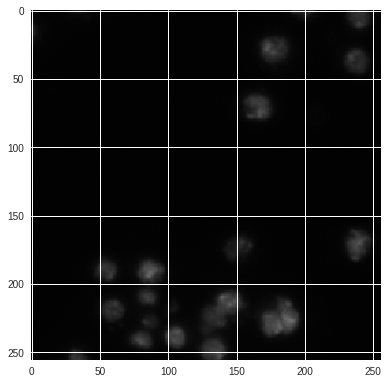

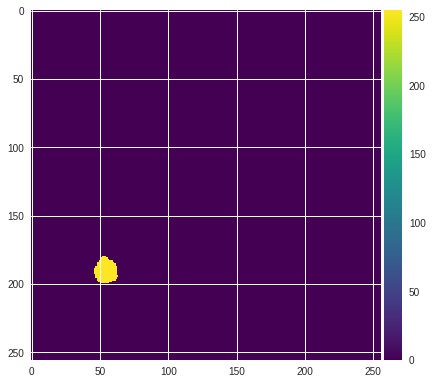

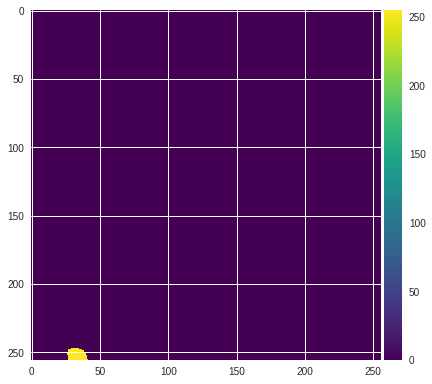

In [ ]:
img = imread("./dataset/data-science-bowl-2018-2/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png")
plt.figure()
imshow(img)

maskImg = imread("./dataset/data-science-bowl-2018-2/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png")
plt.figure()
imshow(maskImg)

maskImg = imread("./dataset/data-science-bowl-2018-2/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png")
plt.figure()
imshow(maskImg)


In [ ]:
# Generates boundinx box (labels) ground truth.
# The labels are based on mask files included in training dataset.
# Mask files are images showing objects in training images.

path_bboxes_csv = "./dataset/data-science-bowl-2018-2/bboxes.csv"
if not os.path.isfile(path_bboxes_csv):
    bboxes = pd.DataFrame(columns=["train_id", "mask_id", "rotby_90", "x", "y", "w", "h"])
    row_count = 1
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + "/" + id_
        for mask_id, mask_file in enumerate(next(os.walk(path + '/masks/'))[2]):
            mask_ = imread(path + '/masks/' + mask_file)
            # To augment training dataset, we rotate mask data.
            for r in range(4):
                bboxes.loc[row_count] = store_bounding_boxes(np.rot90(mask_, r), id_, mask_id, r)
                row_count += 1
    bboxes.to_csv(path_bboxes_csv, index=False)
else:
    bboxes = pd.read_csv(path_bboxes_csv)

In [ ]:
# Define grid cell size.
GRID_DIM = 12
# The width/height of a grid in pixel.
GRID_PIX = IMG_WIDTH//GRID_DIM
BATCH_SIZE = 14

In [ ]:
train_ids_df = pd.DataFrame(columns=["idx", "id_"])
cnt = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    train_ids_df.loc[cnt] = { "idx": n, "id_": id_}
    cnt += 1

train_ids_df = train_ids_df.set_index(['idx'])

100%|██████████| 670/670 [00:01<00:00, 370.26it/s]


In [ ]:
# Grid-based coordinates of box (top-left corner).
bboxes['grid_row'] = bboxes['y']//GRID_PIX
bboxes['grid_column'] = bboxes['x']//GRID_PIX

# The center coordinates of the grid this box is located at.
bboxes['grid_center_x'] = bboxes['grid_column'] * GRID_PIX + GRID_PIX/2
bboxes['grid_center_y'] = bboxes['grid_row'] * GRID_PIX + GRID_PIX/2

# The center coordinates of box center.
bboxes['box_center_x'] = bboxes.x + bboxes['w']/2
bboxes['box_center_y'] = bboxes.y + bboxes['h']/2

bboxes['new_x'] = (bboxes.box_center_x - bboxes.grid_center_x)/(IMG_WIDTH)
bboxes['new_y'] = (bboxes.box_center_y - bboxes.grid_center_y)/(IMG_HEIGHT)

bboxes['new_w'] = np.sqrt(bboxes.w/(IMG_WIDTH))
bboxes['new_h'] = np.sqrt(bboxes.h/(IMG_WIDTH))

# Here there is an object we know. So set object confidence to 1.
bboxes['confidence'] = 1

bboxes['box_area'] = bboxes.new_w*bboxes.new_h

In [ ]:
mask_count = 1
#Set maximum bounding boxes allowed per grid cell
MAX_BB_CNT = 2

In [ ]:
# Returns the label for a given training image id and rotation id.
def get_grid_info(tr_id, rotby_90):
    df = bboxes.loc[(bboxes.train_id == tr_id) & (bboxes.rotby_90 == rotby_90), 'grid_row':'box_area']
    df.drop(['grid_center_x', 'grid_center_y','box_center_x', 'box_center_y',], axis = 1, inplace=True)
    df = df.sort_values(['grid_column', 'grid_row', 'box_area'], ascending=False)
    #print(len(df))
    global mask_count
    mask_count += len(df)
    # Initialize the label ground truth.
    label_info = np.zeros(shape=(GRID_DIM, GRID_DIM, MAX_BB_CNT, 5),  dtype=np.float32) + 0.000001
    
    for ind, row in df.iterrows():
        i = int(row[0])
        j = int(row[1])
        for b in range(MAX_BB_CNT):
            if(label_info[i, j, b][4] != 1.0):
                label_info[i, j, b] = np.array(row[2:7])
                break
    return label_info

In [ ]:
# Returns label ground truth for input data.
# The dimension is (batch size, grid width, grid height, predicted boxes per cell, variables per box).
def get_labels(counts, rotations):
    grid_info = np.zeros(shape=(BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5), dtype=np.float32)
    for i, c in enumerate(counts):
        tr_id = train_ids_df.loc[c, 'id_']
        grid_info[i] = get_grid_info(tr_id, rotations[i])
    grid_info = np.reshape(grid_info, newshape=[BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
    return grid_info

In [ ]:
def get_images(counts, rotations):
    images = np.zeros(shape=(BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
    for i, c in enumerate(counts):
        images[i] = np.rot90(train_images[c], rotations[i])
    return images

In [ ]:
def next_batch():
    rotations = []
    rand_counts = []
    for i in range(BATCH_SIZE):
        rotations.append(random.randint(0, 3))
        rand_counts.append(random.randint(0, 669))
    return get_images(rand_counts, rotations), get_labels(rand_counts, rotations)

In [ ]:
tf.reset_default_graph()
# input: image width x image height x 3 color dimensions.
X = tf.placeholder(tf.float32, [None, IMG_WIDTH, IMG_HEIGHT, 3])
# output: grid * grid * bounding box per cell * 5 variables (x, y, w, h, object confidence)
Y_ = tf.placeholder(tf.float32, [None, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
lr = tf.placeholder(tf.float32)

In [ ]:
# logits: the final output from last convolutional layer.
def process_logits(logits, name=None):
    net = tf.reshape(logits, [-1, GRID_DIM*1, GRID_DIM*1, MAX_BB_CNT*5*16, 1])
    # Each predicted box has only 5 varibales. So takes average value among 5 * 16 values.
    net = tf.layers.average_pooling3d(net, [1, 1, 16], [1, 1, 16], padding="valid")

    # Each cell has 5 output values: (x, y, w, h, object confidence)
    net = tf.reshape(net, [-1, GRID_DIM*GRID_DIM*MAX_BB_CNT, 5]) #GRID_DIM = 12
    net = tf.transpose(net, [1, 2, 0])        

    logits_tensor = tf.map_fn(lambda x:
                            tf.stack([
                                tf.tanh(x[0]),
                                tf.tanh(x[1]),
                                tf.sqrt(tf.sigmoid(x[2])),
                                tf.sqrt(tf.sigmoid(x[3])),
                                tf.sigmoid(x[4])
                            ]), net)

    logits_tensor = tf.transpose(logits_tensor, [2, 0, 1])
    logits_tensor = tf.reshape(logits_tensor, [-1, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])

    return logits_tensor

In [ ]:
# Calculates loss value of model.
def normalize_yolo_loss(processed_logits, lambda_coords, lambda_noobj):
    # The diff between ground truth labels and predicated boxes.
    yolo_loss = tf.reduce_sum(tf.squared_difference(labels, processed_logits), axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)

    # (x, y) coordinate predication goes to multiply given weight: lambda_coords.
    # (object confidence) predication goes to multiply another give weight: lambda_noobj.
    yolo_loss = tf.stack([tf.multiply(lambda_coords, yolo_loss[0]), 
                          tf.multiply(lambda_coords, yolo_loss[1]),
                          yolo_loss[2],
                          yolo_loss[3],
                          tf.multiply(lambda_noobj,yolo_loss[4])])
    yolo_loss = tf.reduce_sum(yolo_loss)

    return  yolo_loss

In [ ]:
def l_relu(features):
    return tf.nn.leaky_relu(features, 0.1)

In [ ]:
# Defines a squeeze layer which has only 1x1 filters.
def squeeze_module(x, dim, idx):
    name = 'conv_' + idx + '_sq'
    return tf.layers.conv2d(x, filters=dim, kernel_size=1, strides=1, padding="same", 
                           activation=l_relu, name=name)

# Defines an expand layer which has a mix of 1x1 and 3x3 filters.
def expand_module(x, dim, idx):
    name = 'conv_' + idx + '_ex_' + '0'
    net1 = tf.layers.conv2d(x, filters=dim, kernel_size=1, strides=1, padding="same", 
                           activation=l_relu, name=name)
    name = 'conv_' + idx + '_ex_' + '1'
    net2 = tf.layers.conv2d(x, filters=dim, kernel_size=3, strides=1, padding="same", 
                           activation=l_relu, name=name) 
    return tf.concat([net1, net2], 3)

In [ ]:
# A Fire module is consisted of a squeeze layer and an expand layer.
def fire_module(input_tensor, squeeze_dim, expand_dim, idx):
    net = squeeze_module(input_tensor, squeeze_dim, idx)
    net = expand_module(net, expand_dim, idx)
    return net

In [ ]:
# Begin to create network
# Defines a SqueezeNet (ICLR 2017).
# Notice: this network definition looks like a bit different to the network in SqueezeNet paper.

net = tf.layers.conv2d(X, filters=32, kernel_size=1, strides=1, padding="same", 
                       activation=l_relu, name='conv0') #384 

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #192

net = fire_module(net, 32, 64, '0')
net = fire_module(net, 32, 64, '1')
net = fire_module(net, 32, 64, '2')

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #96


net = fire_module(net, 64, 96, '3')
net = fire_module(net, 64, 96, '4')
net = fire_module(net, 64, 96, '5')


net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #48

net = fire_module(net, 128, 160, '6')
net = fire_module(net, 128, 160, '7') 
net = fire_module(net, 128, 128, '8')


net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #24

net = fire_module(net, 256, 512, '9')
net = fire_module(net, 256, 512, '10')
net = fire_module(net, 256, 512, '11')

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #12

net = fire_module(net, 512, 1024, '12')
net = fire_module(net, 512, 1024, '13')
net = fire_module(net, 512, 1024, '14')

# Last conv layer.
# Filter numbers are (number of predicted boxes per cell) * (variables per box) * 16
logits = tf.layers.conv2d(net, filters=MAX_BB_CNT*5*16, kernel_size=1, strides=1, padding="same",
                       activation=None, name='conv40') #12

processed_logits = process_logits(logits)

labels = Y_

lambda_coords = tf.constant(5.0)
lambda_noobj = tf.constant(0.5)

yolo_loss = normalize_yolo_loss(processed_logits, lambda_coords, lambda_noobj)

train_op = tf.train.AdamOptimizer(lr).minimize(yolo_loss)

In [ ]:
start_training = True #using pretrained model as Kaggle server doesn't allow training time more than 6 hrs.
if not start_training:
    test_image_id = 33
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, "./models/pre-trained-model/model.ckpt")
        result = sess.run([processed_logits], {X: np.reshape(test_images[test_image_id], [1, 384, 384, 3])})

In [ ]:
if(start_training):
    # initialize
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    batch_count = 0
    display_count = 1
    global mask_count

    for i in range(3300):
        batch_X, batch_Y = next_batch()
        batch_count += 1
        train_loss, _ = sess.run([yolo_loss, train_op], {X: batch_X, Y_: batch_Y, lr: 0.0001})

        if(i % 100 == 0):
            print(str(display_count) + " training loss(" + str(mask_count) + "): " + str(train_loss))
            display_count +=1
        mask_count = 0
    print("Done!")

1 training loss(1747): 4278.211
2 training loss(640): 335.7566
3 training loss(544): 268.99313
4 training loss(648): 291.2823
5 training loss(477): 243.86563
6 training loss(708): 241.25269
7 training loss(743): 192.71835
8 training loss(531): 129.63852
9 training loss(683): 125.52626
10 training loss(660): 117.99341
11 training loss(631): 98.153854
12 training loss(393): 68.14528
13 training loss(414): 48.771812
14 training loss(486): 64.93521
15 training loss(481): 75.795006
16 training loss(782): 63.43609
17 training loss(887): 103.0947
18 training loss(591): 81.386505
19 training loss(647): 62.249516
20 training loss(638): 75.853806
21 training loss(532): 80.4324
22 training loss(895): 82.86041
23 training loss(987): 77.87375
24 training loss(442): 54.96698
25 training loss(623): 85.628555
26 training loss(597): 76.39243
27 training loss(324): 41.28681
28 training loss(418): 27.960213
29 training loss(443): 31.12793
30 training loss(344): 40.068176
31 training loss(1325): 88.12044


In [ ]:
if(start_training):
    test_image_id = 12
    result = sess.run([processed_logits], {X: np.reshape(test_images[test_image_id], [1, 384, 384, 3])})

In [ ]:
boxes = result[0]
print(boxes.shape)
boxes = np.reshape(boxes, newshape=[GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
bbs = []

for i in range(GRID_DIM):
    for j in range(GRID_DIM):
        for b in range(MAX_BB_CNT):
            if(boxes[i][j][b][4]> 0.1):
                grid_center_x = ((j+0)*GRID_PIX + GRID_PIX/2)
                grid_center_y = ((i+0)*GRID_PIX + GRID_PIX/2)
                
                new_box_center_x = boxes[i][j][b][0] * IMG_WIDTH + grid_center_x
                new_box_center_y = boxes[i][j][b][1] * IMG_HEIGHT + grid_center_y

                new_w = np.square(boxes[i][j][b][2]) * IMG_WIDTH
                new_h = np.square(boxes[i][j][b][3]) * IMG_HEIGHT
                
                x1 = new_box_center_x - new_w/2
                y1 = new_box_center_y - new_h/2

                x2 = new_box_center_x + new_w/2
                y2 = new_box_center_y + new_h/2

                bbs.append((math.floor(x1), math.floor(y1), math.ceil(x2), math.ceil(y2)))

(1, 12, 12, 2, 5)


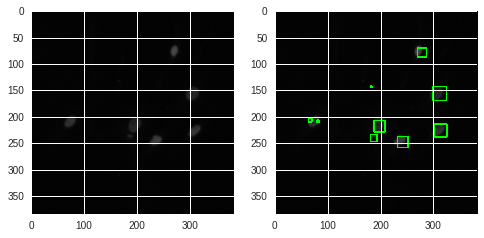

In [ ]:
img = test_images[test_image_id]
f, axs = plt.subplots(1,2)
axs[0].imshow(img)

img_withbbox = np.copy(img)
#imshow(img)
for i, b in enumerate(bbs):
    cv2.rectangle(img_withbbox,(b[0], b[1]),(b[2], b[3]),(0,255,0),2)

axs[1].imshow(img_withbbox)